# Poisson count calibration

This is a demo for using the Poisson count calibration approach we discussed. If you want to learn about Bayesian stats, I'd strongly recommend the book Statistical Rethinking by McElreath. There are also lectures on youtube that accompany the book that are very good.

## Installation instructions
Stan is a statistical programming language. It's a super-fast way for doing Bayesian statistical inference. It fits your statistical model using Hamiltonian Monte Carlo. How it works is you  write a `model.stan` model file that contains your statistical model. You can run this from the command line, but its easier to do it either from R or Python. Here I'm using `cmdstanpy`, which is the Python package I recommend. 

There are installation instructions here: https://mc-stan.org/cmdstanpy/installation.html

Basically install the packages you need in a conda environment, and use that:
```
conda create -n stan -c conda-forge cmdstanpy
```


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cmdstanpy import CmdStanModel

/Users/LOF19/miniconda3/envs/stan/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


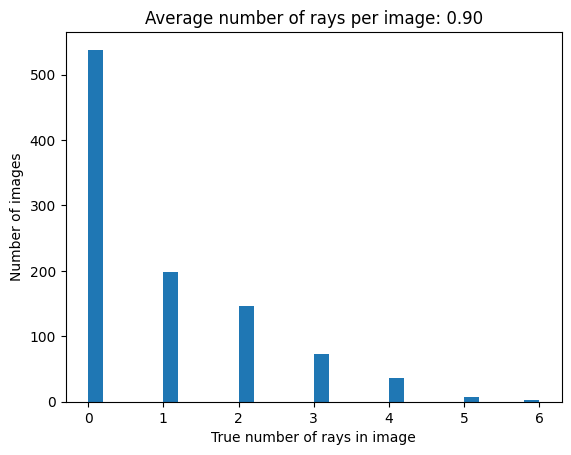

In [2]:
# Biological simulation
zero_inflation_rate = 0.4 # 30% of the time, there's not a ray because no rays present
true_lambda = 1.5         # but given rays are present, average 1.5 rays per image
rng = np.random.default_rng(42)
N_images = 1000
true_counts = rng.binomial(1, 1 - zero_inflation_rate, N_images) * rng.poisson(true_lambda, N_images)

# Maria's labeling effort
N_labeled = 100 # how many images you labeled
N_unlabeled = N_images - N_labeled

# plot these counts
plt.hist(true_counts, bins=30)
plt.xlabel("True number of rays in image")
plt.ylabel("Number of images")
# make the title be the average number of rays per image
plt.title(f"Average number of rays per image: {true_counts.mean():.2f}")
plt.show()

In [3]:
# Simulate the classifier's behavior
alpha_true = 0.2 # even if no rays in the image, the log-odds of 'predicting' a ray are 0.2
beta_true = 0.5  # each ray in the image increases the log-odds of predicting a ray by 0.5
epsilon = 1e-6  # small constant to avoid log(0) TODO: check if necessary

predicted_counts = []
for i in range(N_images):
    intensity = np.exp(alpha_true + beta_true * np.log(true_counts[i] + epsilon))
    predicted_counts.append(rng.poisson(intensity))

# make data numpy arrays for convenience
predicted_counts = np.array(predicted_counts)
true_counts = np.array(true_counts)

# now we 'label' a random subset of images
indices = rng.choice(N_images, N_labeled, replace=False)

# now get the mask for unlabeled
unlabeled_mask = np.ones(N_images, dtype=bool)
unlabeled_mask[indices] = False

pred_labeled = predicted_counts[indices]
truth_labeled = true_counts[indices]

# now we get all the other ones
pred_unlabeled = predicted_counts[unlabeled_mask]
truth_unlabeled = true_counts[unlabeled_mask]


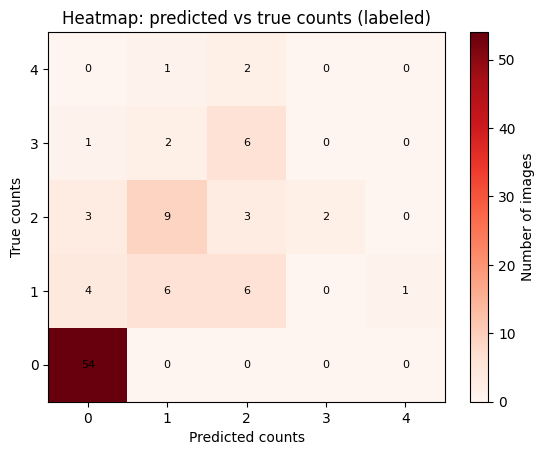

In [4]:
# plot a heatmap of the predicted counts vs the true counts for the labeled data
# Minimal heatmap of predicted vs true counts for labeled data
heatmap, xedges, yedges = np.histogram2d(
    pred_labeled, truth_labeled,
    bins=(np.arange(pred_labeled.max()+2)-0.5, np.arange(truth_labeled.max()+2)-0.5)
)

fig, ax = plt.subplots()
im = ax.imshow(
    heatmap.T,
    origin='lower',
    aspect='auto',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Reds'
)
plt.colorbar(im, ax=ax, label='Number of images')
ax.set_xlabel("Predicted counts")
ax.set_ylabel("True counts")
ax.set_title("Heatmap: predicted vs true counts (labeled)")

# Add the cell values as text annotations
for i in range(heatmap.shape[0]):
    for j in range(heatmap.shape[1]):
        count = int(heatmap[i, j])
        x = xedges[i] + 0.5  # Center of each bin in x
        y = yedges[j] + 0.5  # Center of each bin in y
        ax.text(x, y, str(count), color='black', ha='center', va='center', fontsize=8)

plt.show()


In [7]:
# COM-Poisson model: same data as single-site Poisson (no N_sites or site_id)
data = {
    "N_labeled": N_labeled,
    "N_unlabeled": N_unlabeled,
    "predicted_counts_labeled": pred_labeled,
    "true_counts_labeled": truth_labeled,
    "predicted_counts_unlabeled": pred_unlabeled,
    "epsilon": epsilon,
}
model = CmdStanModel(stan_file="stan_models/COM_poisson_count_calibration.stan")
fit = model.sample(data=data, seed=123, show_progress=False)

11:54:10 - cmdstanpy - INFO - compiling stan file /Users/LOF19/maria_poisson_calibration/stan_models/COM_poisson_count_calibration.stan to exe file /Users/LOF19/maria_poisson_calibration/stan_models/COM_poisson_count_calibration


ValueError: Failed to compile Stan model '/Users/LOF19/maria_poisson_calibration/stan_models/COM_poisson_count_calibration.stan'. Console:

--- Translating Stan model to C++ code ---
bin/stanc --filename-in-msg=COM_poisson_count_calibration.stan --o=/Users/LOF19/maria_poisson_calibration/stan_models/COM_poisson_count_calibration.hpp /Users/LOF19/maria_poisson_calibration/stan_models/COM_poisson_count_calibration.stan
Semantic error in 'COM_poisson_count_calibration.stan', line 108, column 9 to column 10:
   -------------------------------------------------
   106:      }
   107:      log_num_terms[1] = 0;  // j = 0: mu^0 / (0!)^nu = 1
   108:      for (k in 2 : (y + 1)) {
                  ^
   109:        log_num_terms[k] = (k - 1) * log_mu - nu * lgamma(k);  // j = k-1
   110:      }
   -------------------------------------------------

Identifier "k" is already in use.
make: *** [make/program:66: /Users/LOF19/maria_poisson_calibration/stan_models/COM_poisson_count_calibration.hpp] Error 1

Command ['make', 'STANCFLAGS+=--filename-in-msg=COM_poisson_count_calibration.stan', '/Users/LOF19/maria_poisson_calibration/stan_models/COM_poisson_count_calibration']
	exited with code '2' No such file or directory


In [6]:
# Target: average number of rays per image (population mean) and its 90% credible interval
mean_rays = fit.stan_variable("mean_rays_per_image")
print(f"Average rays per image: posterior mean = {mean_rays.mean():.3f}")
print(f"90% credible interval: [{np.percentile(mean_rays, 5):.3f}, {np.percentile(mean_rays, 95):.3f}]")
# Compare to the true value (we know it in this simulation)
print(f"(True average in simulation: {true_counts.mean():.3f})")

Average rays per image: posterior mean = 0.904
90% credible interval: [0.757, 1.062]
(True average in simulation: 0.900)


In [7]:
# Posterior predictive for unlabeled: true counts should fall in intervals
rep = fit.stan_variable("true_counts_unlabeled_rep")  # shape (draws, N_unlabeled)
lo, hi = np.percentile(rep, [5, 95], axis=0)
covered = np.sum((truth_unlabeled >= lo) & (truth_unlabeled <= hi)) / N_unlabeled
print(f"90% posterior predictive interval coverage of true unlabeled counts: {covered:.0%}")

90% posterior predictive interval coverage of true unlabeled counts: 96%


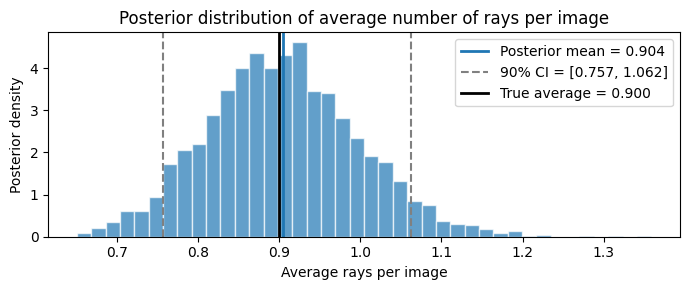

In [8]:
# Visualization: posterior of average rays per image (the quantity we care about)
mean_rays = fit.stan_variable("mean_rays_per_image")
lo, hi = np.percentile(mean_rays, [5, 95])

plt.figure(figsize=(7, 3))
plt.hist(mean_rays, bins=40, color="C0", alpha=0.7, edgecolor="white", density=True)
plt.axvline(mean_rays.mean(), color="C0", lw=2, label=f"Posterior mean = {mean_rays.mean():.3f}")
plt.axvline(lo, color="gray", ls="--", lw=1.5, label=f"90% CI = [{lo:.3f}, {hi:.3f}]")
plt.axvline(hi, color="gray", ls="--", lw=1.5)
plt.xlabel("Average rays per image")
plt.ylabel("Posterior density")
plt.title("Posterior distribution of average number of rays per image")
# also plot the truth as a vertical line
truth = sum(true_counts) / N_images
plt.axvline(truth, color="black", lw=2, label=f"True average = {truth:.3f}")
plt.legend()
plt.tight_layout()
plt.show()